In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import sklearn
from sklearn import *
from sklearn.metrics import *
import pickle

In [2]:
playerList = []
statList = [[],
[],
[],
[],
[],
[],
[],
[]]
predList = []
actList = []

In [3]:
DATADIR = "C:/Users/ali49/OneDrive/Desktop/NBAPredictionTool/AllNBAPredictionTool/AllNBAPred/DataSet.csv"
dataSet = pd.read_csv(DATADIR)
dataSet = dataSet[['Player', 'PTS', 'TRB', 'AST', 'GPnSround%', 'PER', 'WS', 'BPM', 'VORP', 'All-NBA?']]

In [4]:
a=dataSet.pop('Player')
A=np.array(a)

In [5]:
predict = 'All-NBA?'
X = np.array(dataSet.drop([predict], 1))
Y = np.array(dataSet[predict])

In [6]:
best=0
trueNegative = 0	
truePositive = 0	
falseNegative = 0	
falsePositive = 0
for _ in range(50):

    trainA, testA, trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(A, X, Y, test_size=0.3)
    clf = svm.SVC(kernel="linear")
    clf.fit(trainX, trainY)
    acc= clf.score(testX, testY)

    if acc > best:
        best = acc
        with open("studentmodel.pickle", "wb") as f:
            pickle.dump(clf, f)

In [7]:
pickle_in = open("studentmodel.pickle", "rb")
clf = pickle.load(pickle_in)
y_pred = clf.predict(testX)
stats = 'PTS', 'TRB', 'AST', 'GPnSround%', 'PER', 'WS', 'BPM', 'VORP'

In [8]:
for x in range(len(y_pred)):

    if y_pred[x]==0 and y_pred[x]==testY[x]:
        trueNegative = trueNegative + 1

    if y_pred[x]==1 and y_pred[x]==testY[x]:
        truePositive = truePositive + 1

    if y_pred[x] == 0 and y_pred[x] != testY[x]:
            falseNegative = falseNegative + 1

    if y_pred[x] == 1 and y_pred[x] != testY[x]:
                falsePositive = falsePositive + 1

    if y_pred[x] == 1 or testY[x] ==1:
        playerList.append(testA[x])
        predList.append(y_pred[x])
        actList.append(testY[x])

        for y in range(len(stats)):
            statList[y].append(testX[x][y])
           

In [9]:
Precision = float(precision_score(testY, y_pred))
Recall = float(recall_score(testY, y_pred))
f1Score = float((2*Precision*Recall)/(Precision+Recall))

In [10]:
print(trueNegative)
print(truePositive)
print(falseNegative)
print(falsePositive)

312
21
1
1


In [11]:
print(Precision)
print(Recall)
print(f1Score)

0.9545454545454546
0.9545454545454546
0.9545454545454546


In [13]:
x1='PTS'
y1 = 'GPnSround%'
x=dataSet[x1]
y=dataSet[y1]
z=dataSet[predict]

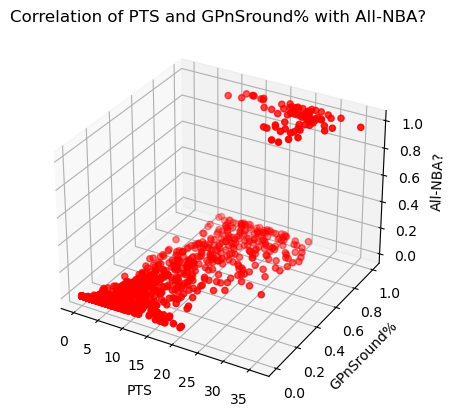

In [14]:
ax = plt.axes(projection='3d')
ax.set_xlabel(x1)
ax.set_ylabel(y1)
ax.set_zlabel(predict)
ax.scatter(x,y,z, color='red')
ax.set_title('Correlation of %s and %s with %s' % (x1, y1, predict))
plt.show()

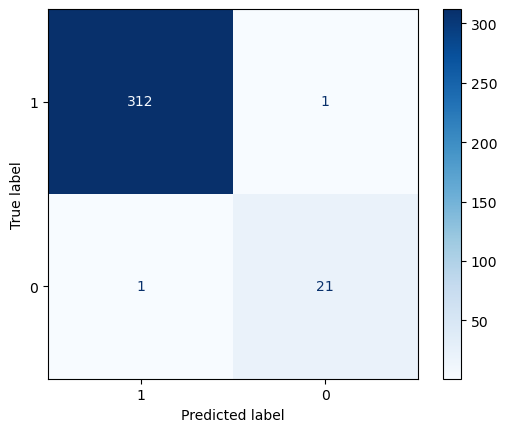

In [15]:
plot_confusion_matrix(clf,testX, testY, cmap = "Blues", display_labels = ['1', '0'])

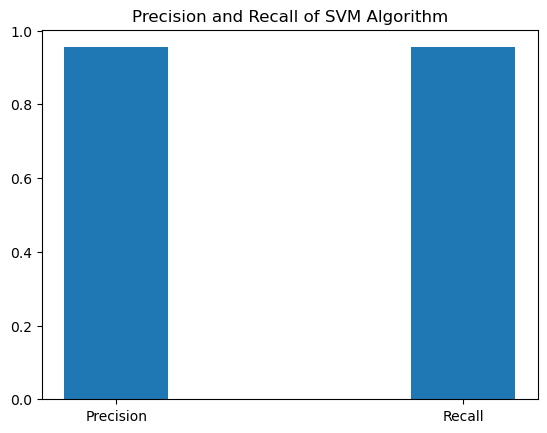

In [18]:
pnrLabel = ['Precision', 'Recall']
pnrResult = [Precision, Recall]
plt.bar(pnrLabel, pnrResult, width = 0.3)
plt.title('Precision and Recall of SVM Algorithm')
plt.show()